# Pytorch Object Detection: Hands-On

The hands on example will build a "simple" YOLO-like Object Detection model in 5 steps:
    
1. Build a model using a pre-trained VGG-16 network as feature extractor
2. Preprocess and load Pascal VOC dataset
3. Define YOLO loss function
4. Train model (example, because this would take a while)
5. Test model

Along the way we will explain relevant pytorch concepts.

### Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Imports

In [2]:
import torch 
import torchvision
from torch import nn
from torch.utils.data import DataLoader

from scipy.misc import imread, imresize
import os
import collections
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### Parameters

Data Parameters

In [3]:
IMG_FOLDER    = '../data/VOCdevkit/VOC2012/JPEGImages'
ANN_FOLDER    = '../data/VOCdevkit/VOC2012/labels'
FILE          = '../data/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
IMG_SIZE      = 224
LABELS_VOC    = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog',
                 'horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

Model parameters

In [4]:
C             = 20       # number of classes
S             = 7        # number of grid cells in x and y direction

Training parameters

In [27]:
NUM_EPOCHS    = 135
BATCH_SIZE    = 16       # 64 as per YOLO paper, adjusted for GPU memory constraints  
LEARNING_RATE = 0.001/4.
DEVICE        = 'cuda'

Prediction parameters

In [6]:
C_THRESHOLD   = 0.3      # only count predictions where confidence exceeds threshold

### Data

Download and prepare Pascal VOC dataset.

#### Download Data

Download dataset from official source and preprocess using script provided by YOLO author
- VOC data from http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit.
- Generate labels using `wget https://pjreddie.com/media/files/voc_label.py`

#### Preprocess Data

Parse file indices and bounding boxes into lookup arrays and dictionaries. 

In [7]:
# create list and dictionary containing parsed bboxes and labels
images = []
labels = collections.defaultdict(list)
bboxes = collections.defaultdict(list)
        
# read files and fill a list of labels and bounding boxes
with open(FILE) as f:
    lines = f.readlines()
    
for line in lines:
    # read image information from index file
    img_file = os.path.join(IMG_FOLDER, line[:-1] + '.jpg')
    images.append(img_file)
    ann_file = os.path.join(ANN_FOLDER, line[:-1] + '.txt')
    # parse annotations in generated file
    anns = np.genfromtxt(ann_file, delimiter=' ').reshape(-1, 5)
    for ann in anns:
        labels[img_file].append(ann[0])
        bboxes[img_file].append(torch.Tensor(ann[1:]))

Resulting in...

In [8]:
images[:5]

['../data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg',
 '../data/VOCdevkit/VOC2012/JPEGImages/2008_000015.jpg',
 '../data/VOCdevkit/VOC2012/JPEGImages/2008_000019.jpg',
 '../data/VOCdevkit/VOC2012/JPEGImages/2008_000023.jpg',
 '../data/VOCdevkit/VOC2012/JPEGImages/2008_000028.jpg']

In [9]:
labels[images[0]]

[12.0, 14.0]

In [10]:
bboxes[images[0]]

[tensor([0.5240, 0.5735, 0.8360, 0.7534]),
 tensor([0.4470, 0.2387, 0.2620, 0.2783])]

#### Convert data to YOLO input

Iterate over each image/annotation and transform to YOLO expected training input. For S = 7, B = 2, C = 20 produce Tensor of shape (7, 7, 30). 

For 7x7 grid, determine for each:
1. For 2 boundary boxes (x, y, w, h, confidence)
2. Probabilities for 20 classes

Through the following steps:
1. Determine cell center of object falls into
2. Convert x, y to the center of the box relative to grid location (normalized to [0,1])
3. Normalize w, h relative to total image size
4. Determine confidence score as `P(Object) * IOU(pred, truth)`. If no object exists in cell, confidence score is zero `P(Object) = 0`.
5. Determine class probabilities as `P(Class_i | Object)`, probablity that `Object is` of `Class_i` IF Object exists in grid.

To simplify we will set `B=1` from here on. Implementing for multiple B is left as an exercise to the reader.

<img src="https://cdn-images-1.medium.com/max/1600/1*oXSVP0HPVIaZqPpSinxsRQ.png" width="65%">

In [11]:
# dict to store preprocessed targets for images
targets = {}

# iterate over all images in VOC train data
for img_path in images:  
    # retrieve stored bboxes and labels
    img_bboxes = bboxes[img_path].copy()
    img_labels = labels[img_path].copy()
    
    # create output Tensor for training target
    target = torch.zeros([S, S, 5 + C])
    # track number of bounding boxes per grid
    bbobj = np.zeros([S, S], dtype=int)
    
    # iterate over all boxes & labels for image
    for i, label in enumerate(img_labels):
        bb = img_bboxes[i]
        # 1. Determine cell center of object falls into ----------------------------------------------------------
        # a. Get center of object in x and y direction
        x  = bb[0] 
        y  = bb[1]
        # b. Determine cell for object
        cx = int(np.floor(x * S))
        cy = int(np.floor(y * S))
        # c. Stop if more than B boxes for grid location have been found
        if bbobj[cx, cy] == 1:
            break
        bbobj[cx, cy] = 1
        # 2. Convert x, y to the center of the box relative to grid location -------------------------------------
        xc = (x - (cx / S)) / (1 / S)  
        yc = (y - (cy / S)) / (1 / S)  
        # 3. Normalize w, h relative to total image size ---------------------------------------------------------
        # -> already in correct format thanks to voc_label.py script
        # 4. Determine confidence score -> Cell contains object = 1 else 0 ---------------------------------------
        # a. store all
        target[cx, cy, 0] = xc
        target[cx, cy, 1] = yc
        target[cx, cy, 2] = bb[2]
        target[cx, cy, 3] = bb[3]
        target[cx, cy, 4] = 1.
        # 5. Determine class probabilities as P(Class_i | Object) ------------------------------------------------
        # -> probablity that Object is of Class_i IF Object exists in grid
        target[cx, cy, 5 + int(label)] = 1.

    # store 
    targets[img_path] = target

Encapsulate above in `torch.utils.data.Dataset`.

In [12]:
class YoloVOCDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets, img_size):
        self.images   = images
        self.targets  = targets
        self.img_size = img_size

    def __getitem__(self, index):
        # retrieve data for index
        img_path = self.images[index]
        target = self.targets[img_path]
        # load image
        image = imread(img_path) 
        # format image
        image = imresize(image, (self.img_size, self.img_size))
        image = image / 255.
        image = torch.Tensor(image)
        # return tuple containing image and target Tensor
        return image, target

    def __len__(self):
        return len(images)

Create an iterator to process the training dataset.

In [13]:
voc = YoloVOCDataset(images, targets, IMG_SIZE)
train_data = DataLoader(voc, batch_size=4, shuffle=True, num_workers=0)
train_iter = iter(train_data)

At this point a function to plot images with annotated bounding boxes comes in handy.

In [14]:
def plot(img, target):
    # convert numpy array back to image
    im = (img.numpy()*255.).astype('uint8')
    # setup plot
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    # go through each cell cx, cy in grid
    for cx in range(0, S):
        for cy in range(0, S):
            # and plot if confidence is above threshold
            cell = target[cx, cy, :].numpy()
            if cell[4] >= C_THRESHOLD:
                # some magic to take yolo data format and convert it to matplotlib expected format
                label_txt = LABELS_VOC[np.argmax(cell[5:])]
                x = (cx/S + cell[0]*(1/S) - cell[2]/2) * IMG_SIZE
                y = (cy/S + cell[1]*(1/S) - cell[3]/2) * IMG_SIZE
                w = cell[2] * IMG_SIZE
                h = cell[3] * IMG_SIZE
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='red', facecolor='None')
                ax.add_patch(rect)
                plt.text(x + 2, y + 12, label_txt, color='red')

    plt.show()

Rerun below to generate new image with annotations.

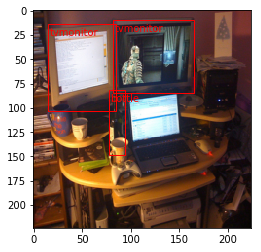

In [15]:
img, target = next(train_iter)
plot(img[0], target[0])

**What is missing?**

- Parsing of test data (same with above, new Iterator)
- Data augmentation, in YOLO:
  - Random scaling and translations of up to 20% of the original image size
  - Randomly adjust the exposure and saturation of the image by up to a factor of 1.5 in the HSV color space

### Loss Function

The YOLO Loss function overall has 4 parts. The $\lambda$ parameter used throughout can be used to give different weights to different parts of the loss function.

**1. Predicted box position**

$\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2]$

- Computes a sum over each bounding box predictor (0..B) for each grid cell (0...S*S)
- $1^{obj}$ determines if an object is present in cell $i$ and the bounding box $j$ is the responsible predictor (1, 0 otherwise) 
- Responsible predictor is the predictor which has the highest current IOU with the ground truth
- Sum all squared errors from predicted $x$, $y$ and original $\hat{x}$, $\hat{y}$  

**2. Predicted box width / height**

$\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{w_i}-\sqrt{\hat{w}_i})^2]$

- Similar to the above for width and height
- Only differences are the square roots. Reason: Small deviations in large boxes matter less than in small boxes. 

**3. Loss associated with confidence score**

$\sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}(C_i-\hat{C}_i)^2 + \lambda_{noojb}  \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{noobj}(C_i-\hat{C}_i)^2$

- $C$ is the confidence score and $\hat{C}$ is the IoU of the predicted bounding box with the ground truth
- $1^{obj}$ determines if an object is present in cell, $1^{noobj}$ is the opposite

**4. Classification loss**

$\sum_{i=0}^{S^2}\unicode{x1D7D9}_{ij}^{obj}\sum_{c \in classes}(p_i(c)-\hat{p}_i(c))^2$

- Normal sum-squared error for classification plus $1^{obj}$ term, which ensures no penalization applies when no object is present in call

** Total Loss **

All elements of the loss added results in:
    
$$\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2]$$
$$+ \lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{w_i}-\sqrt{\hat{w}_i})^2]$$
$$+ \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{obj}(C_i-\hat{C}_i)^2 + \lambda_{noojb}  \sum_{i=0}^{S^2}\sum_{j=0}^{B}\unicode{x1D7D9}_{ij}^{noobj}(C_i-\hat{C}_i)^2$$
$$+ \sum_{i=0}^{S^2}\unicode{x1D7D9}_{ij}^{obj}\sum_{c \in classes}(p_i(c)-\hat{p}_i(c))^2$$

Implement custom loss as `nn.Module`.

In [16]:
class YoloLoss(nn.Module):
    
    def __init__(self, lambda_coord = 5, lambda_noobj = 0.5, S = 7, C = 20, verbose = True):
        super(YoloLoss, self).__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.S = S
        self.C = C
        self.verbose = verbose


    def forward(self, output, target):
        batch_size = target.size(0)
        
        # 0. calculate 1obj and 1noobj ---------------------------------------------------------------------------
        cls_target = target[:, :, :, 5:]
        # cls_target is of shape [batch_size, S, S, classes]
        # sum class predictions for cell in grid
        cls_sum = torch.sum(cls_target, 3) 
        # cls_sum is of shape [batch_size, S, S]
        # find indices for which the sum is greater than 0 (object present)
        mask_1obj = cls_sum.gt(0)
        # or equal 0 (no object present)
        mask_nobj = cls_sum.eq(0)
        
        # 1. Predicted Bounding Box position ---------------------------------------------------------------------
        # retrieve x and y from input Tensors
        target_o = target[mask_1obj]
        output_o = output[mask_1obj]
        
        # retrieve x and y from input tensors
        target_x = target_o[:, 0]
        target_y = target_o[:, 1]
        output_x = output_o[:, 0]
        output_y = output_o[:, 1]

        # calculate xy loss
        loss_xy = torch.sum((output_x - target_x) ** 2 + (output_y - target_y) ** 2) / mask_1obj.shape[0]
        if self.verbose: print("loss_xy=", loss_xy.item())
        
        # 2. Predicted box width / height ------------------------------------------------------------------------
        # retrieve w and y from input Tensors
        target_w = target_o[:, 2]
        target_h = target_o[:, 3]
        output_w = output_o[:, 2]
        output_h = output_o[:, 3]
        
        # calculate loss / ignore sqrt term
        loss_wh = torch.sum((output_w - target_w) ** 2 + (output_h - target_h) ** 2) / mask_1obj.shape[0]
        if self.verbose:print("loss_wh=", loss_wh.item())

        # 3. Loss associated with confidence score ---------------------------------------------------------------
        # sum squared diff between confidence score and IoU of predicted bounding box with ground truth
        # for cells with object in ground truth
        output_conf = output_o[:, 4]
        output_bbox = output_o[:, 0:4]
        target_bbox = target_o[:, 0:4]
        target_cxcy = mask_1obj.nonzero().float()[:, 1:3] / self.S
        
        # get intersection and set negative values to 0
        dx = torch.min(target_cxcy[:, 0] + output_bbox[:, 0]/self.S + output_bbox[:, 2]/2,   \
                       target_cxcy[:, 0] + target_bbox[:, 0]/self.S + target_bbox[:, 2]/2) - \
             torch.max(target_cxcy[:, 0] + output_bbox[:, 0]/self.S - output_bbox[:, 2]/2,   \
                       target_cxcy[:, 0] + target_bbox[:, 0]/self.S - target_bbox[:, 2]/2) 
        dx = dx.clamp(0)
        dy = torch.min(target_cxcy[:, 1] + output_bbox[:, 1]/self.S + output_bbox[:, 3]/2,   \
                       target_cxcy[:, 1] + target_bbox[:, 1]/self.S + target_bbox[:, 3]/2) - \
             torch.max(target_cxcy[:, 1] + output_bbox[:, 1]/self.S - output_bbox[:, 3]/2,   \
                       target_cxcy[:, 1] + target_bbox[:, 1]/self.S - target_bbox[:, 3]/2)
        dy = dy.clamp(0)
        inter = dx * dy
    
        # get box areas and resulting union
        output_area = output_bbox[:, 2]*output_bbox[:, 3]
        target_area = target_bbox[:, 2]*target_bbox[:, 3]
        union = output_area + target_area - inter
        ious = inter / union
        # calculate loss as difference between IoU and conf
        loss_1obj = torch.sum((output_conf - ious) **2) / mask_1obj.shape[0]
        
        if self.verbose: print("loss_1obj=", loss_1obj.item())
            
        # next calculate confidence loss for cells with no object in ground truth 
        # (=> no IoU with ground truth)
        output_nc = output[mask_nobj][:, 4]
        loss_nobj = torch.sum(output_nc ** 2) / mask_1obj.shape[0]
    
        if self.verbose: print("loss_nobj=", loss_nobj.item())
        
        # 4. Classification loss ---------------------------------------------------------------------------------
        output_cl = output_o[:, 5:]
        target_cl = target_o[:, 5:]
        # calculate difference between predicted and target classes
        cls_diff = (target_cl - output_cl) ** 2
        # sum the diffs
        loss_cl = torch.sum(cls_diff) / mask_1obj.shape[0]
        
        if self.verbose: print("loss_cl=", loss_cl.item())
        
        # 5. calculate total -------------------------------------------------------------------------------------
        total_loss = self.lambda_coord * loss_xy + \
                     self.lambda_coord * loss_wh + \
                     self.lambda_noobj * loss_nobj + loss_1obj + \
                     loss_cl
        
        return total_loss

Initiate loss.

In [17]:
loss = YoloLoss()

And test on random sample input.

In [21]:
img, target = next(train_iter)

print(loss.forward(target[0:2], target[0:2]))
print(" ")
print(loss.forward(target[0:2], target[2:4]))

loss_xy= 0.0
loss_wh= 0.0
loss_1obj= 8.704148513061227e-14
loss_nobj= 0.0
loss_cl= 0.0
tensor(8.7041e-14)
 
loss_xy= 1.0468692779541016
loss_wh= 1.4821758270263672
loss_1obj= 0.43238183856010437
loss_nobj= 0.5
loss_cl= 2.5
tensor(15.8276)


**What is missing?**

- B>1
- Anchor boxes

### Network

#### Feature Extractor: VGG-16

Use a pre-trained model as feature extractor for the network. VGG16 is available through `torchvision.models`.

Add fully connected output layers to feature extraction network.

https://github.com/pjreddie/darknet/blob/master/cfg/vgg-16.cfg

In [22]:
model = torchvision.models.vgg16(pretrained=True)

# optionally exclude feature layers from gradient updates
# for param in model.parameters():
#    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, S * S * (5 + C))
                                 )
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Overwrite weight and bias initializations for added linear model classifier.

In [23]:
for m in model.modules():
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.01)
        m.bias.data.zero_()

Layers: 
- Conv2D
  - Applies a 2D convolution over an input signal composed of several input planes
  - `kernel_size` (int or tuple): Size of the convolving kernel
  - `stride` (int or tuple, optional): Stride of the convolution. Default: 1
  - `padding` (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
- ReLU
  - Applies the rectified linear unit function element-wise 
  - $\text{ReLU}(x)= \max(0, x)$
- MaxPool2D
  - Applies a 2D max pooling over an input signal composed of several input planes.
  - `kernel_size`: the size of the window to take a max over
  - `stride`: the stride of the window. Default value is `kernel_size`
  - `padding`: implicit zero padding to be added on both sides
  - `dilation`: a parameter that controls the stride of elements in the window
  - `ceil_mode`: when `True`, will use `ceil` instead of `floor` to compute the output shape
- Linear
  - Applies a linear transformation to the incoming data 
  - $y = xA^T + b$
- Dropout
  - During training, randomly zeroes some of the elements of the input tensor with probability `p`

**What is missing?**
- Increase input resolution of the network from 224 × 224 to 448 × 448
- LeakyReLU instead of ReLU

### Train Model

YOLO Training procedure as per paper:
- Epochs and batch size
  - 135 epochs
  - Batch size of 64, 
- Optimizer
  - Momentum of 0.9 and decay of 0.0005
- Learning rate
  - For the first epochs, the learning rate was slowly raised from 0.001 to 0.01. 
  - Train for about 75 epochs and then start decreasing it.
  - We will ignore learning rate adjustments to simplify. This could be achieved through `torch.optim.lr_scheduler.StepLR`

Define Dataset, Loss and Optimizer.

In [28]:
train_data = YoloVOCDataset(images, targets, img_size = IMG_SIZE)
train_data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
n_batches  = len(train_data)
criterion  = YoloLoss(verbose=False) 
model      = model.to(DEVICE)
optimizer  = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train model for number of epochs.

In [29]:
for epoch in range(NUM_EPOCHS):
    
    loss_sum = 0.0
    
    for batch_idx, (img, target) in enumerate(train_data):
        
        # FORWARD PASS
        # format img to NCHW and pass to model on GPU
        target = target
        img    = img.permute([0,3,1,2]).to(DEVICE)
        output = model.forward(img).view(-1, S, S, 5 + C)
        
        # calculate loss on CPU
        loss = criterion.forward(output.cpu(), target)
        loss_sum += loss.item()
        
        # BACKWARD PASS 
        # zero gradients (at the start of a minibatch)
        optimizer.zero_grad()

        # computes dloss/dx for every parameter x
        loss.backward()
   
        # optimizer.step performs a parameter update based on the current gradients
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, NUM_EPOCHS, loss_sum / n_batches))

Epoch [1/135], Loss: 5.3671
Epoch [2/135], Loss: 4.6632
Epoch [3/135], Loss: 4.5043
Epoch [4/135], Loss: 4.3372
Epoch [5/135], Loss: 4.2010
Epoch [6/135], Loss: 4.0508
Epoch [7/135], Loss: 3.9279
Epoch [8/135], Loss: 3.7597
Epoch [9/135], Loss: 3.6341
Epoch [10/135], Loss: 3.4971
Epoch [11/135], Loss: 3.3659
Epoch [12/135], Loss: 3.2515
Epoch [13/135], Loss: 3.0859
Epoch [14/135], Loss: 2.9280
Epoch [15/135], Loss: 2.7892
Epoch [16/135], Loss: 2.6839
Epoch [17/135], Loss: 2.5469
Epoch [18/135], Loss: 2.4010
Epoch [19/135], Loss: 2.3185
Epoch [20/135], Loss: 2.2082
Epoch [21/135], Loss: 2.0943
Epoch [22/135], Loss: 2.0121
Epoch [23/135], Loss: 1.9333
Epoch [24/135], Loss: 1.8689
Epoch [25/135], Loss: 1.7937
Epoch [26/135], Loss: 1.7399
Epoch [27/135], Loss: 1.6858
Epoch [28/135], Loss: 1.6146
Epoch [29/135], Loss: 1.5532
Epoch [30/135], Loss: 1.5155
Epoch [31/135], Loss: 1.4929
Epoch [32/135], Loss: 1.4548
Epoch [33/135], Loss: 1.4088
Epoch [34/135], Loss: 1.3675
Epoch [35/135], Loss: 1

Save model.

In [33]:
torch.save(model.state_dict(), 'model.ckpt')

**What is missing?**

- Adjustment of learning rate during training
- Validation on separate dataset during training

### Inference Example

Load model.

In [34]:
model2 = torchvision.models.vgg16(pretrained=False)
model2.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                  nn.ReLU(True),
                                  nn.Dropout(0.5),
                                  nn.Linear(4096, 4096),
                                  nn.ReLU(True),
                                  nn.Dropout(0.5),
                                  nn.Linear(4096, S * S * (5 + C))
                                  )
model2.load_state_dict(torch.load('model.ckpt'))

Get a training image for quick validation of approach (note: potentially overfitted, evaluation on separate test set required).

In [35]:
train_data = DataLoader(voc, batch_size=1, shuffle=True, num_workers=0)
train_iter = iter(train_data)
img, target = next(train_iter)

Plot ground truth.

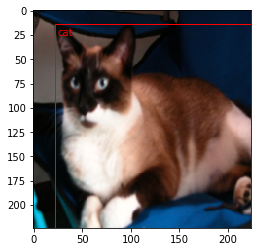

In [36]:
plot(img[0], target[0])

Plot predicted classes.

tensor([[0.8360, 0.7053, 0.9000, 0.9413, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.7277, 0.6527, 0.9562, 0.8816, 0.9240, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


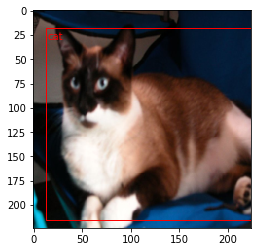

In [37]:
with torch.no_grad():
    #prediction = model.forward(img.permute([0,3,1,2]).to(DEVICE)).view(-1, S, S, 5 + C).cpu()
    prediction = model2.forward(img.permute([0,3,1,2])).view(-1, S, S, 5 + C)
    prediction = torch.clamp(prediction, min=0.0, max=1.0)[0]
    # filter by confidence threshold
    conf_mask = prediction[:,:,4].gt(C_THRESHOLD)
    prediction = prediction.permute([2,0,1]) * conf_mask.float()
    prediction = prediction.permute([1,2,0])
    if conf_mask.sum() >= 1:
        # select single class
        class_max = prediction[conf_mask][:, 5:25].eq(torch.max(prediction[conf_mask][:, 5:25]))
        class_max = torch.cat([prediction[conf_mask][:, 0:5], class_max.float()], dim=-1)
        prediction[conf_mask] = class_max
        # compare with target
        print(target[0][conf_mask])
        print(prediction[conf_mask])
    else:
        print("No object detected with confidence")
    # plot
    plot(img[0], prediction)

**What is missing?**
- Calculate mAP on distinct VOC test dataset

### Inspired By 
- https://gitlab.com/EAVISE/lightnet/tree/master/examples/yolo-voc
- https://github.com/makora9143/yolo-pytorch/blob/master/yolov1/loss.py
- https://github.com/happyjin/pytorch-YOLO
- https://github.com/makatx/YOLO_ResNet

### Other Examples

- https://github.com/c0nn3r/RetinaNet (193*)
- https://github.com/yhenon/pytorch-retinanet (49*)
- https://github.com/amdegroot/ssd.pytorch (1120*)
- https://github.com/eriklindernoren/PyTorch-YOLOv3 (439*)
- https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch (633*)

------

**Additional Sources**
- https://cv-tricks.com/object-detection/faster-r-cnn-yolo-ssd/
- https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/
- https://blog.athelas.com/a-brief-history-of-cnns-in-image-segmentation-from-r-cnn-to-mask-r-cnn-34ea83205de4
- http://cs231n.stanford.edu/slides/2018/cs231n_2018_ds06.pdf
- https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088
- https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b
- https://datascience.stackexchange.com/questions/25119/how-to-calculate-map-for-detection-task-for-the-pascal-voc-challenge
- https://medium.com/@umerfarooq_26378/from-r-cnn-to-mask-r-cnn-d6367b196cfd
- https://mc.ai/yolo3-a-huge-improvement/
- https://medium.com/@smallfishbigsea/notes-on-focal-loss-and-retinanet-9c614a2367c6
- https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3
- https://zsc.github.io/megvii-pku-dl-course/slides/Lecture6(Object%20Detection).pdf
- https://hackernoon.com/understanding-yolo-f5a74bbc7967